In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
import argparse
from sklearn.metrics import roc_curve as ROC
from sklearn.metrics import auc,brier_score_loss

from Utils.loading import *
from Utils.treino import *
from Utils.init_redes import *
from Utils.KD import *
from Utils.ensemble import *
from Utils.redes import *
from Utils.data_set import *
from Utils.cobertura import *
from Utils.graficos import *

cuda


In [2]:
if torch.cuda.is_available():
    device = 'cuda'  
else:
    device = 'cpu'
print(device)

cuda


In [3]:
data_set = "Cifar100"

if data_set == "Cifar10":
    transform_train, transform_test, batch_size, trainset, trainloader, testset, testloader, classes = cifar10()
elif data_set == "Cifar100":
    transform_train, transform_test, batch_size, trainset, trainloader, testset, testloader= cifar100()

Files already downloaded and verified
Files already downloaded and verified


In [149]:
student = init_rede("Resnet100")
student3 = init_rede("Resnet100")

students = [student,student3]

n_nets = 15 # numero de redes no ensamble
temp1 = 4
temp2 = 2
#temp = 10

print("Loading Students")
students = load_student_resnet(students, data_set,n_redes=n_nets, temp1=temp1, temp2=temp2)
#students = load_teste_temp(students, data_set, temp)
print("End")


print("Loading Ensamble")
nets_ensemble = load_resnet18(n_nets, data_set)
for i in range(n_nets):
    nets_ensemble[i].eval()
print("End")

n_redes = 4 # 2 Students + Ensemble + Resnet18

Loading Students
End
Loading Ensamble
End


In [150]:
# Calcula a acuracia da rede
outputs = torch.tensor([]).to("cuda")
outputs2 = torch.tensor([]).to("cuda")

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        
        outputs_0 = caculate_outputs(students,images)
        outputs_0 = torch.stack(tuple(outputs_0),dim=0)
        outputs = torch.cat((outputs,outputs_0),dim=1)
    outputs = torch.nn.functional.softmax(outputs, dim=-1)

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        
        outputs_2 = caculate_outputs(nets_ensemble,images.to('cuda')) # cria uma lista onde cada index é o resultado de uma das redes
        outputs_2 = torch.stack(tuple(outputs_2),dim=0) # transfor a lista em um tensor [15,100,10]
        outputs2 = torch.cat((outputs2,outputs_2),dim=1) # junta os tensores na segunda dim ex: [15,100,10] -> [15,200,10]        
    outputs2 = torch.nn.functional.softmax(outputs2, dim=-1)
        
ensamble_1_14 = torch.stack((outputs2[0], torch.mean(outputs2,dim=0)),dim=0) # Junta o primeiro ensamble com o ultimo
outputs = torch.cat((outputs,ensamble_1_14),dim=0) # unta o primeiro ensamble com o ultimo com os students
#outputs = torch.nn.functional.softmax(outputs, dim=-1)

In [151]:
predict_list = list()
uncs_max_list = list()
for i in range(n_redes):
    uncs_max, _, _, predict = calculate_predicted(outputs[i])
    predict_list.append(predict) # calcula a probabilidade de cada assemble
    uncs_max_list.append(uncs_max) # calcula a probabilidade de cada assemble

predict_cat = torch.stack(tuple(predict_list),dim=0) # Junta as respostas
uncs_max_cat = torch.stack(tuple(uncs_max_list),dim=0) # Junta as respostas

In [152]:
images_cat = torch.tensor([])
labels_cat = torch.tensor([])

for i, data in enumerate(testloader, 0):
        images, labels = data
        images_cat = torch.cat((images_cat,images),dim=0) # Junta as respostas
        labels_cat = torch.cat((labels_cat,labels),dim=0) # Junta as respostas

In [153]:
correct_list = list()
covarege_list1 = list()
covarege_list2 = list()
covarege_list3 = list()
for i in range(n_redes):
    correct_list.append(calculate_correct(predict_cat[i], labels_cat))
    covarege_list1.append(RC_curve(predict_cat[i],labels_cat.to("cuda"),uncs_max_cat[i]))

# AUROC e AURC

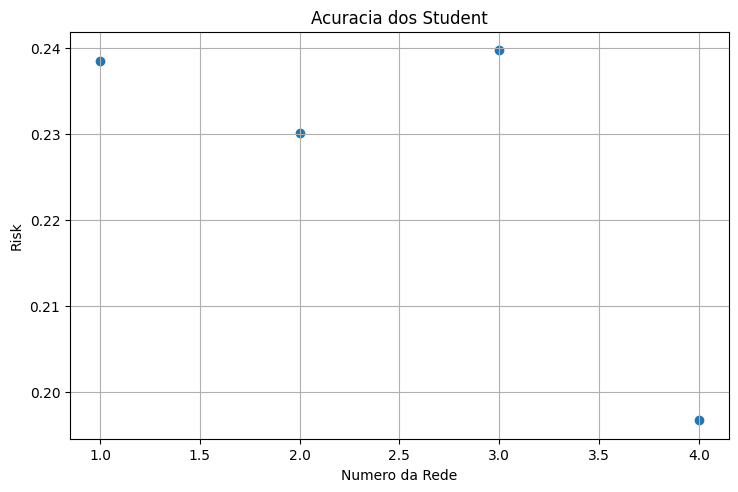

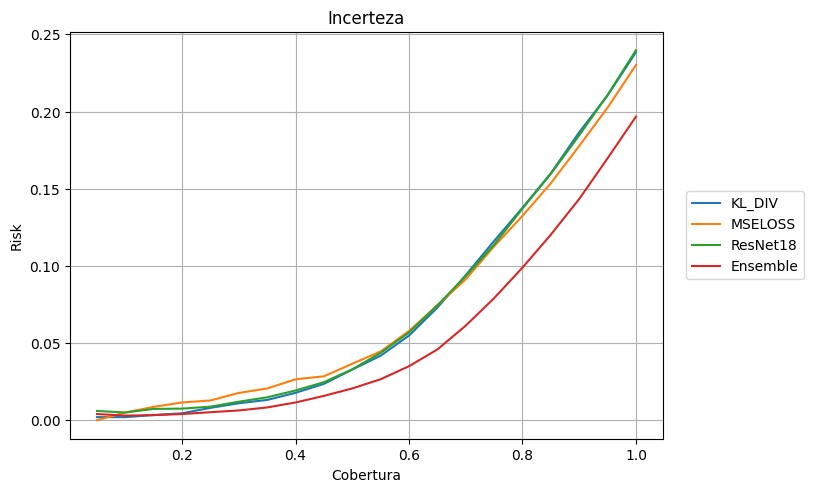

In [154]:
import matplotlib
import matplotlib.pyplot as plt

# Todosos graficos juntos
g1 = plot_graph(X = [1,2,3,4], Y = correct_list, title="Acuracia dos Student", xlabel="Numero da Rede",ylabel="Risk", line=False)

g2 = plot_mutiple_graph(X=np.arange(0.05,1.05,0.05),Y=covarege_list1,title="Incerteza",xlabel="Cobertura",ylabel="Risk",label="KL_DIV,MSELOSS,ResNet18,Ensemble",multi_label=True,n_graphs=n_redes)

In [155]:
for i in range(4):
    area_sobre_curva = auc(np.arange(0.05,1.05,0.05), covarege_list1[i])
    print((1-correct_list[i])*100, " ",area_sobre_curva)

76.16000000000001   0.06552956398134027
76.99000000000001   0.06648446539313799
76.03   0.06646359411958867
80.33   0.04791259930257219


In [156]:
# TESTE ENSEMBLE
g1.savefig('/home/luigi-doria/IC/Graficos/KD/{}/{} Redes/Acuracia.png'.format(data_set,n_nets))
g2.savefig('/home/luigi-doria/IC/Graficos/KD/{}/{} Redes/Incerteza.png'.format(data_set,n_nets))


# TESTE TEMPERATURA
#g1.savefig('/home/luigi-doria/IC/Graficos/KD/Teste de Temperatura/{}/Temp {}/Acuracia.png'.format(data_set,temp))
#g2.savefig('/home/luigi-doria/IC/Graficos/KD/Teste de Temperatura/{}/Temp {}/Incerteza.png'.format(data_set,temp))